# Slavic masked language models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import lru_cache
from itertools import combinations, product

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from scipy.stats import pearsonr

from gest import stereotype_names
from masked_models.utils import tokenize
from utils import bootstrap_ci, set_size, visualize_corr, all_languages

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
models = [
    'bert-base-multilingual-cased',
    'xlm-roberta-base',
    'xlm-roberta-large',
    'facebook/xlm-v-base',
    'facebook/xlm-roberta-xl',
]

def short_model_name(model):
    for s in ('uncased', 'v2', 'cased', 'generator'):
        if model.endswith('-' + s):
            model = model[:-len(s)-1]
    model = model.split('/')[-1]
    if model.endswith('lingual'):
        model = model[:-7]
    return model

## Basic visualizations

In [20]:
def file_results(filename):
    return list(map(float, open(filename, 'r').readlines()))

@lru_cache
def model_results(model):

    df = pd.read_csv('./data/gender_variants.csv')

    tokenizer = AutoTokenizer.from_pretrained(model)
    def tokenizer_check(row):
        mw = tokenizer.tokenize(row.male)
        fw = tokenizer.tokenize(row.female)
        return len(mw) == len(fw) and sum(mwx != fwx for mwx, fwx in zip(mw, fw)) == 1

    def first_letter_check(row):
        mws, fws = row.male.split(), row.female.split()
        for mw, fw in zip(mws, fws):
            if mw != fw:
                return mw[0] == fw[0]

    df['score'] = file_results(f'./cache/predictions/mmlm/{model.split("/")[-1]}.txt')
    return df[(
        df.apply(first_letter_check, axis=1) &
        df.apply(tokenizer_check, axis=1) &
        ~df.duplicated(['male', 'female'])
    )]

@lru_cache
def r_i(model, language, stereotype_id, bootstrap=True):
    """
    Average score for stereotype _i_
    """
    df = model_results(model)
    vals = df[(df.stereotype == stereotype_id) & (df.language == language)].score
    
    if bootstrap:
        return bootstrap_ci(list(vals))
    else:
        return np.mean(vals)

def r_is(model, language, bootstrap=True):
    """
    Averages for all 16 stereotypes
    """
    return [r_i(model, language, stereotype_id, bootstrap) for stereotype_id in range(1, 17)]

def r_f(model, language):
    """
    Average score $r_i$ for female stereotypes
    """
    return np.mean([
        r_i(model, language, stereotype_id, bootstrap=False)
        for stereotype_id in range(1, 8)
    ]) 

def r_m(model, language):
    """
    Average score $r_i$ for male stereotypes
    """
    return np.mean([
        r_i(model, language, stereotype_id, bootstrap=False)
        for stereotype_id in range(8, 17)
    ]) 

def g_s(model, language):
    """
    Overall stereotype rate
    """
    return r_m(model, language) - r_f(model, language)

def r_i_ranks(model, language):
    return np.argsort(np.argsort(r_is(model, language, bootstrap=False))) + 1

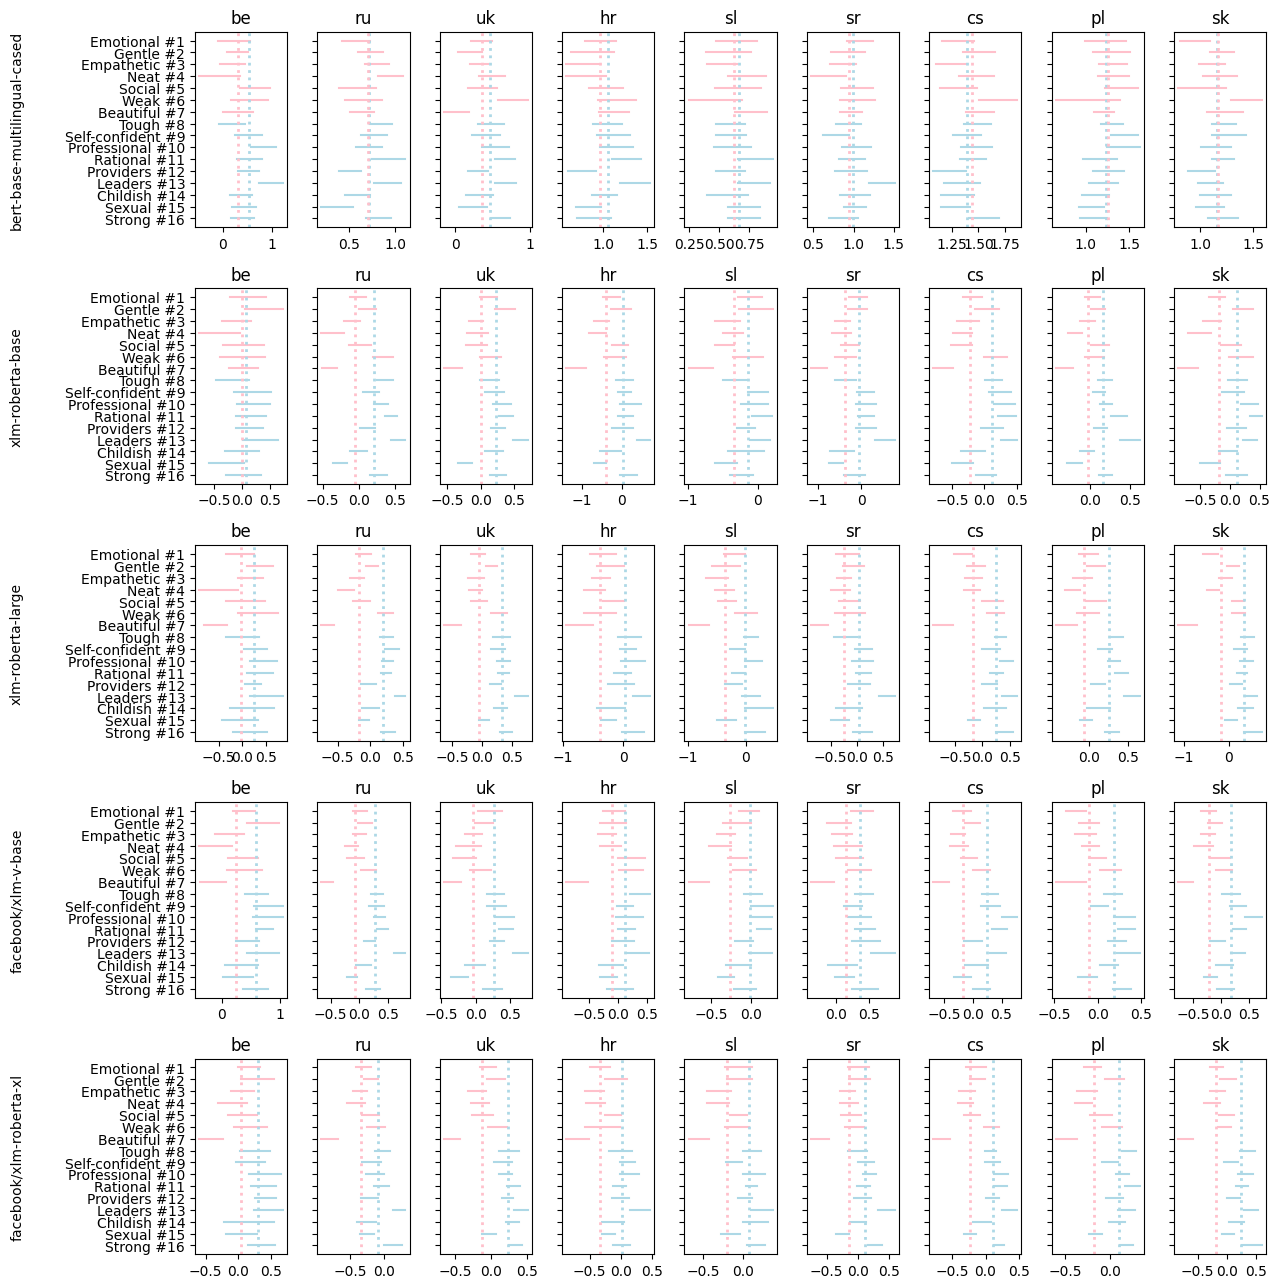

In [5]:
fig, axes = plt.subplots(5, 9, sharey=True)
axes[0][0].invert_yaxis()

for i, model in enumerate(models):
    for ax, language in zip(axes[i], all_languages):
        if ax == axes[i][0]:
            ax.set_ylabel(model)
        ax.set_title(language)
        for stereotype_id in range(1, 17):
            _, lower, upper = r_i(model, language, stereotype_id)
            ax.plot([lower, upper], [stereotype_id, stereotype_id], c=('pink' if stereotype_id < 8 else 'lightblue'))
        # ax.set_xlim(0, 1)
        ax.set_yticks(range(1, 17), stereotype_names)
        ax.axvline(r_m(model, language), linestyle=':', linewidth=2, color='lightblue')
        ax.axvline(r_f(model, language), linestyle=':', linewidth=2, color='pink')

set_size(10, 10)
plt.tight_layout()
plt.savefig('./figures/ml_all.pdf')

In [7]:
def format_ci(mean, lower, upper):
    return f'{lower:.2f} {mean:.2f} {upper:.2f}'

for model in models:
    print('\\midrule')
    print("& \multicolumn{16}{l}{\\texttt{", end='')
    print(model, end='')
    print("}} \\\\")
    for language in all_languages:
        print(language, *[
            format_ci(*r_i(model, language, stereotype_id))
            for stereotype_id in range(1, 17)
        ], sep=' & ', end=' \\\\\n')

\midrule
& \multicolumn{16}{l}{\texttt{bert-base-multilingual-cased}} \\
be & -0.12 0.21 0.55 & 0.08 0.30 0.51 & -0.05 0.21 0.46 & -0.49 -0.06 0.35 & 0.37 0.67 0.96 & 0.14 0.55 0.99 & 0.01 0.30 0.60 & -0.11 0.19 0.47 & 0.26 0.53 0.81 & 0.57 0.84 1.10 & 0.31 0.56 0.81 & 0.32 0.53 0.74 & 0.72 0.98 1.23 & 0.15 0.38 0.61 & 0.18 0.43 0.69 & 0.17 0.40 0.63 \\
ru & 0.41 0.57 0.74 & 0.60 0.74 0.87 & 0.68 0.80 0.93 & 0.82 0.95 1.08 & 0.39 0.59 0.79 & 0.46 0.65 0.85 & 0.51 0.64 0.77 & 0.73 0.84 0.96 & 0.65 0.78 0.91 & 0.57 0.72 0.87 & 0.76 0.93 1.10 & 0.39 0.51 0.63 & 0.77 0.92 1.08 & 0.45 0.59 0.73 & 0.21 0.38 0.55 & 0.68 0.82 0.95 \\
uk & 0.20 0.35 0.49 & 0.04 0.20 0.36 & 0.20 0.33 0.45 & 0.32 0.49 0.66 & 0.16 0.36 0.56 & 0.58 0.77 0.97 & -0.15 0.01 0.19 & 0.31 0.47 0.64 & 0.22 0.41 0.60 & 0.36 0.54 0.72 & 0.53 0.67 0.81 & 0.17 0.30 0.44 & 0.53 0.67 0.82 & 0.13 0.32 0.51 & 0.04 0.23 0.42 & 0.48 0.61 0.74 \\
hr & 0.79 0.97 1.15 & 0.62 0.88 1.12 & 0.58 0.77 0.98 & 0.58 0.80 1.02 & 0.84 1.03 1.22

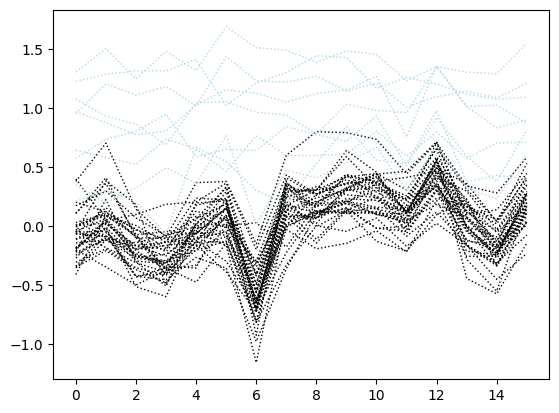

In [24]:
"""
Consistent behavior across models except mBERT
"""
for model in models[1:]:
    for language in all_languages:
        plt.plot(
            r_is(model, language, bootstrap=False),
            c='black',
            linestyle=':',
            linewidth=1,
        )

# mBERT is showed in lightblue
for language in all_languages:
    plt.plot(
        r_is(models[0], language, bootstrap=False),
        c='lightblue',
        linestyle=':',
        linewidth=1,
    )

In [18]:
@lru_cache
def r_i(model, language, stereotype_id, bootstrap=True):
    print(1)
    """
    Average score for stereotype _i_
    """
    df = model_results(model)
    vals = df[(df.stereotype == stereotype_id) & (df.language == language)].score
    
    if bootstrap:
        return bootstrap_ci(list(vals))
    else:
        return np.mean(vals)



1


(0.21215553665343595, -0.11197873228313299, 0.5356664065903785)

In [19]:
r_i(models[0], all_languages[0], 1, True)
r_i(models[0], all_languages[0], 1, True)

(0.21215553665343595, -0.11197873228313299, 0.5356664065903785)

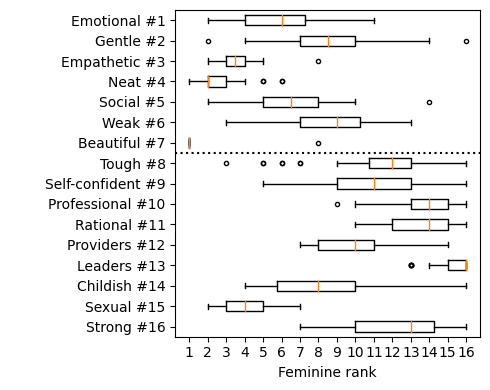

In [26]:
"""
Boxplot of positions (the rank in the list of 16 stereotypes) for all stereotypes.

The split between male and female stereotypes is more obvious now, as we "normalized" the results across different setups.
"""
plt.rcParams["figure.figsize"] = (5,4)

ranks = np.vstack([
    r_i_ranks(model, language)
    for model in models[1:]
    for language in all_languages
])
plt.boxplot(ranks, vert=False, sym='.');
plt.axhline(7.5, c='black', linestyle=':')
plt.gca().invert_yaxis()
plt.xticks(range(1,17))
plt.yticks(range(1,17), stereotype_names)
plt.xlabel('Feminine rank')
plt.tight_layout()
plt.savefig('./figures/ml_ranks.pdf')

/tmp/ipykernel_1552/1467932970.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  d = np.vstack(


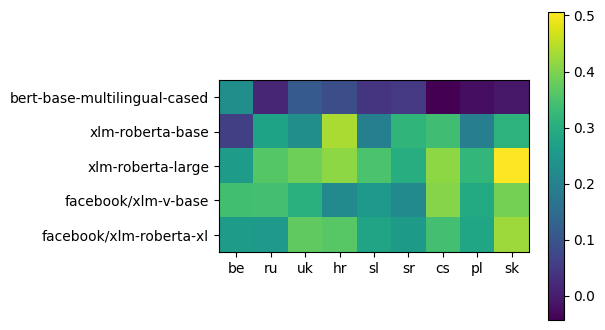

In [30]:
"""
mBERT has really low stereotype rate
"""
plt.xticks(range(9), all_languages)
plt.yticks(range(5), models)
d = np.vstack(
    [
        g_s(model, language)
        for language in all_languages
    ]
    for model in models
)
plt.colorbar(plt.imshow(d))

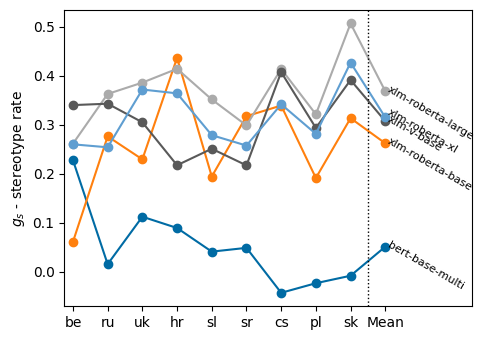

In [35]:
plt.rcParams["figure.figsize"] = (5, 3.5)

means = np.mean(d, axis=1)
plt.plot(np.vstack([d.T, means]), marker='o')
for i, model in enumerate(models):
    model_name = short_model_name(model)
    ver_offset = {'xlm-roberta-xl': +0.007}.get(model_name, 0)
    plt.text(9.05, means[i] + ver_offset, model_name, fontsize=8, rotation=-30, rotation_mode='anchor')
plt.xticks(range(10), all_languages + ['Mean'])
plt.axvline(8.5, linestyle=':', linewidth=1, color='black')
plt.xlim(-0.25, 11.5)
plt.ylabel('$g_s$ - stereotype rate')
plt.tight_layout()
plt.savefig('./figures/ml_languages.pdf')

## Other info

In [43]:
"""
Yield per language and translator
"""
df = pd.read_csv('./data/gender_variants.csv')
df = pd.DataFrame(df[df.male.str[0] == df.female.str[0]])

print(*([''] + all_languages), sep=' & ', end=' \\\\\n')
for translator_class in sorted(set(df.translator.values)):
    print(*(
        [translator_class] + 
        [
            sum((df.translator == translator_class) & (df.language == language))
            for language in all_languages
        ]
    ),
    sep=' & ',
    end=' \\\\\n',
    )


 & be & ru & uk & hr & sl & sr & cs & pl & sk \\
AmazonTranslate & 0 & 1072 & 1382 & 1346 & 1280 & 1377 & 1457 & 1048 & 942 \\
DeepL & 0 & 1309 & 1161 & 0 & 1196 & 0 & 1361 & 1381 & 1420 \\
GoogleTranslate & 959 & 1386 & 1132 & 1249 & 1220 & 1358 & 1224 & 1237 & 1238 \\
NLLB & 581 & 863 & 731 & 541 & 547 & 604 & 676 & 667 & 645 \\


In [44]:
"""
Yield per language and translator
"""
for model in models:
    print(model, len(model_results(model)))

bert-base-multilingual-cased 17054
xlm-roberta-base 16087
xlm-roberta-large 16087
facebook/xlm-v-base 16576
facebook/xlm-roberta-xl 16087


In [263]:
"""
Yield per language
"""
sum((df.male.str[0] == df.female.str[0]) & ~df.duplicated(['male', 'female'])) / 9

2966.6666666666665

In [46]:
"""
Yield per language after tokenization
"""
min([len(model_results(model)) for model in models]) / 9, max([len(model_results(model)) for model in models]) / 9

(1787.4444444444443, 1894.888888888889)

## Correlation

In [52]:
r_i_results = {
    (model, language): r_is(model, language, bootstrap=False)
    for model, language in product(models[1:], all_languages)
}

In [53]:
"""
Average correlation overall
"""
np.mean([
    pearsonr(res1, res2)[0]
    for res1, res2 in combinations(r_i_results.values(), 2)
])

0.8187956619324372

In [54]:
"""
1. Correlation between models for the same language
2. Correlation between languages for the same model
"""
(
    np.mean([
        np.mean([
            pearsonr(r_i_results[model1, language], r_i_results[model2, language])[0]
            for model1, model2 in combinations(models[1:], 2)
        ])
        for language in all_languages
    ]),
    
    np.mean([
        np.mean([
            pearsonr(r_i_results[model, language1], r_i_results[model, language2])[0]
            for language1, language2 in combinations(all_languages, 2)
        ])
        for model in models[1:]
    ]),
)

(0.8590201509082139, 0.8435077372731143)

## Family-related terms

0.31102682513908575 0.05056380169271232 0.12404165742619079


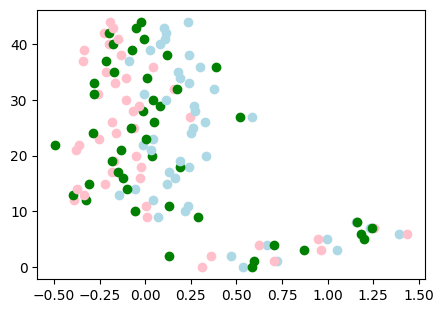

In [59]:
family_words = 'family child children partner kids kid family\'s'.split()

def family_rate(model, language):
    df = model_results(model)
    df = df[(df.language == language) & (df.stereotype > 7)]  # Male samples in given language
    df = df[df.original.apply(lambda sentence: any(word in sentence for word in family_words))]  # With family words
    return np.mean(df.score)

al, bl, cl = [], [], []
for i, (model, language) in enumerate(product(models, all_languages)):
    a, b, c = r_m(model, language), r_f(model, language), family_rate(model, language)
    plt.scatter([a], [i], c='lightblue')
    plt.scatter([b], [i], c='pink')
    plt.scatter([c], [i], c='green')
    al.append(a); bl.append(b); cl.append(c)
print(np.mean(al), np.mean(bl), np.mean(cl))
